In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Read all dataframe from 9geek website.
# c = constituency; candi = candidate
pwd = "9geek_dataset/"
info_c9 = pd.read_csv(pwd + "info_constituency9.csv")
info_party9 = pd.read_csv(pwd + "info_party9.csv")
info_province9 = pd.read_csv(pwd + "info_province9.csv")
result_partylist9 = pd.read_csv(pwd + "result_partylist9.csv")
result_cstatus9 = pd.read_csv(pwd + "result_constituency_status9.csv")
result_candi9 = pd.read_csv(pwd + "result_candidate9.csv")

# After identifying errors in the 9geek dataset, I manually corrected the dataset using ThaiPBS election result. 
id_name = dict(zip(info_party9["id"], info_party9["name"]))

# After identifying errors in the 9geek dataset, I manually corrected the dataset using ThaiPBS election result. 
info_province = pd.read_csv("PL_info_province.csv")
result_candi = pd.read_csv("PL_result_constituencies_CandidateConst.csv")
result_overall = pd.read_csv("PL_result_constituencies_Overall.csv").rename(columns = {"Unnamed: 0":"cons_id"})
result_overall = result_overall.drop(columns = result_overall.columns.tolist()[4:]).set_index("cons_id")

# TLDR

I have provided several sanity checks for users of the dataset. The dataset provided on Github titled **PL_result_constituencies_CandidateConst.csv** and **PL_result_constituencies_Overall.csv** passed all of the sanity check, and the results for each constituency match those from the ECT official website. You are welcome to use the constituency datasets as you see fit. However, please **credit** Peem Lerdputtipongporn for processing the final version of this dataset and the 9geek volunteers for the original version of the dataset.

# Sanity Check 1: Voters per constituency 
**Object**: info_c9
1. Few constituencies should have fewer than 100,000 or more than 150,000 eligible voters (True).
- Only Mae Hong Sorn (MSN), Pang Nga (PNA), and Pattani (PTN) should have constituencies with fewer than 100,000 voters. 
- Likewise, only 10 districts have more than 150,000 registered voters. 
2. The number of eligible voters in each constituency should not differ by a factor greater than 2 (False).
- TRT_1 (Trat District 1) has more than 175,000 registered votes, whereas MSN_1 (Mae Hong Sorn District 1) has only 87,000.
3. ECT definitely divides the constituency such that each has approximately equal number of constituents. Hence, the histogram of eligible voters per constituency should be approximately normally distributed (True).

In [31]:
# Ratio between maximum registered voters and minimum of all constituencies.
info_c9["registered_vote"].max()/info_c9["registered_vote"].min()

2.006393436987981

In [34]:
# Number of districts with more than 150,000 registered votes. 
info_c9[info_c9["registered_vote"] > 150000]["cons_id"].unique()

array(['ACR_2', 'LPG_2', 'LPG_4', 'LPN_1', 'LPN_2', 'PKN_1', 'SBR_1',
       'SKM_1', 'SKN_1', 'SKN_3', 'TAK_1', 'TRT_1'], dtype=object)

(array([  4.,   5.,  16.,  51., 123., 132.,  53.,  11.,   2.,   3.]),
 array([ 87277. ,  96060.5, 104844. , 113627.5, 122411. , 131194.5,
        139978. , 148761.5, 157545. , 166328.5, 175112. ]),
 <BarContainer object of 10 artists>)

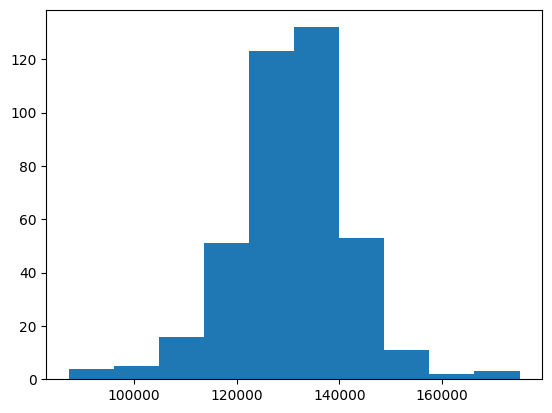

In [38]:
# Each constituency is further divided into zones (i.e., district) but the registered vote is tallied at a constituency-level.
# Therefore, we can drop duplicate constituents and plot the histogram. 
temp = info_c9.drop_duplicates(subset=['cons_id','registered_vote'])
plt.hist(temp["registered_vote"])

# Sanity Check 2: Constituency and province

**Object**: info_c9 and info_province

1. The number of registered votes per province should equal to the sum of registered votes across all constituencies in the province. That is, let $V_{i}$ be the number of votes in province $i$ and $\mathcal{C}_i$ the number of votes per constituency in province $i$. The following must hold: $$V_i = \sum\limits_{c \in C_i} c$$ (True).

2. Basic facts
- The sum of eligible votes should be around 50 million (True).
- 77 provinces and 400 constituencies in the previous election.
- Major provinces in Thailand, such as Bangkok, Nonthaburi, Khon Kaen, Chiang Mai, Nakorn Ratchasima, Surat Thani, etc. should have the largest number of registered votes (True).

3. The number of votes per voting station should contain no outlier (e.g., differ by a factor greater than 2) (True).

In [81]:
# Vote per province = sum of votes across all constituencies within the province
temp1 = info_province.set_index("prov_id")
temp2 = info_c9.drop_duplicates("cons_id").groupby("prov_id").sum()["registered_vote"]
for index in temp.index.tolist():
    assert temp1.loc[index]["total_registered_vote"] == temp2.loc[index]

In [114]:
# Basic facts
assert sum(temp2) > 5*(10**7) ## The total number of registered votes should be around 50 million.
assert len(info_province["prov_id"].unique()) == 77
assert len(info_c9["cons_id"].unique()) == 400

In [116]:
## Most populous provinces and highest number of registered votes.
temp2.sort_values(ascending=False)[:15]

prov_id
BKK    4479155
NMA    2120399
UBN    1473971
KKN    1449595
CMI    1331007
BRM    1250148
UDN    1248824
CBI    1234192
NST    1220778
SSK    1162288
SKA    1098389
SRN    1090337
SPK    1086284
NBI    1056364
RET    1054706
Name: registered_vote, dtype: int64

# Sanity Check 3: Total votes for any candidate and overall turnout

**Object**: result_candi and result_overall

1. The histogram of registered votes per constituency are concentrated around $100,000-160,000$ votes. Assuming a turnout ratio of $75-90\%$ and $5\%$ invalid or no-vote ballot, there should be few constituencies with fewer than $70,000$ or greater than $130,000$ votes (True).

2. Most constituencies should have turnout of around $70-80\%$. For districts with extremely high or low turnout in comparison to others, verify the information with the ECT official website (True, did not detect any inconsistency). 

3. Historically, there should be around $3-5\%$ of invalid ballots and no more than $5\%$ of no-votes. After checking with the ECT offical website, the results are confirmed to be true. Indeed, there are districts with very high invalid ballot.

,mp_app_id,mp_app_rank,mp_app_vote,percent,party_id
cons_id,,,,,
LPN_1,LPN_1_3LPN_1_1LPN_1_9LPN_1_7LPN_1_4LPN_1_6LPN_...,78,137569,99.99,8748
LPN_2,LPN_2_2LPN_2_4LPN_2_8LPN_2_1LPN_2_5LPN_2_7LPN_...,91,131375,99.99,9537


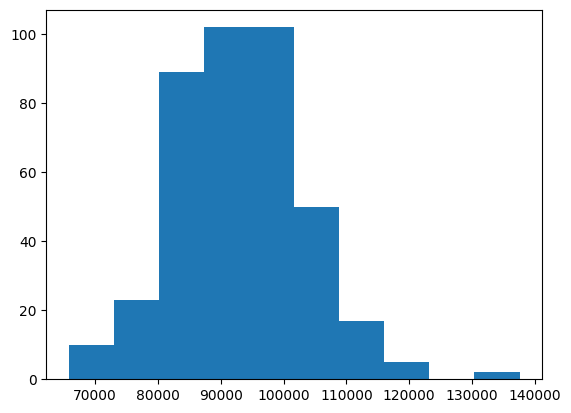

In [129]:
# Total ballot cast for any candidate should be around 70k-130k.
total_vote = result_candi.groupby("cons_id").sum()

plt.hist(total_vote["mp_app_vote"])
total_vote[total_vote["mp_app_vote"] < 70000]
total_vote[total_vote["mp_app_vote"] > 130000]

In [179]:
# Plot the distribution of overall turnout.
turnout_lst = []
high_turnout = []
low_turnout = []
temp = info_c9.drop_duplicates("cons_id").set_index("cons_id")
for index in result_overall.index.tolist():
    total_vote = sum(result_overall.loc[index])
    registered_vote = temp["registered_vote"].loc[index]
    turnout = total_vote/registered_vote
    if(turnout < 0.67):
        low_turnout.append(index)
    elif(turnout > 0.83):
        high_turnout.append(index)
    turnout_lst.append(turnout)

Text(0.5, 1.0, 'Histogram of turnout ratio per constituency')

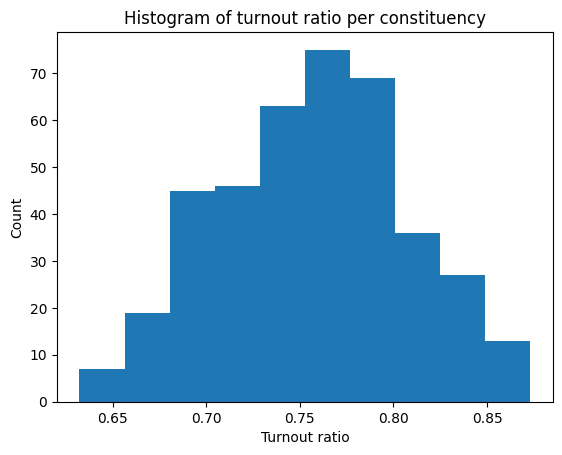

In [174]:
plt.hist(turnout_lst)
plt.xlabel("Turnout ratio")
plt.ylabel("Count")
plt.title("Histogram of turnout ratio per constituency")

In [190]:
# Calculate the ratio of invalid ballot and no-votes
err_ratio = [np.round(result_overall.loc[index]["Candidate_Err"]/sum(result_overall.loc[index]),3)
             for index in result_overall.index.tolist()]
no_vote_ratio = [np.round(result_overall.loc[index]["Candidate_NoVote"]/sum(result_overall.loc[index]),3)
                 for index in result_overall.index.tolist()]
result_overall["err_ratio"] = err_ratio
result_overall["no_vote_ratio"] = no_vote_ratio

(array([60., 99., 88., 73., 52., 16.,  6.,  2.,  3.,  1.]),
 array([0.005 , 0.0113, 0.0176, 0.0239, 0.0302, 0.0365, 0.0428, 0.0491,
        0.0554, 0.0617, 0.068 ]),
 <BarContainer object of 10 artists>)

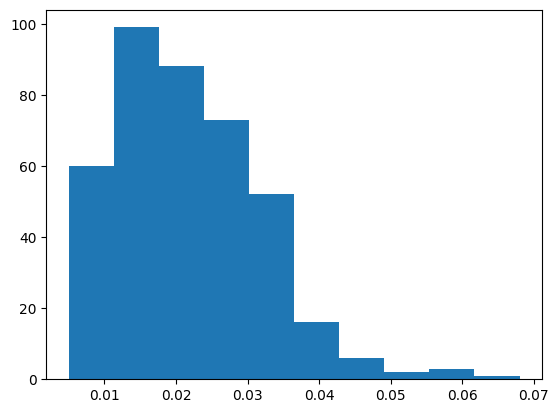

In [193]:
plt.hist(result_overall["no_vote_ratio"])

# Sanity Check 4: Do results from the dataset match the announced results?

1. The number of constituency seats each party acquires must match the election result (True).
2. The total number of votes each party obtains must match the official result.

In [237]:
# Find the party obtaining highest number of seats in each constituency
highest_vote = result_candi.sort_values(by = ["cons_id", "mp_app_vote"], ascending = False).drop_duplicates("cons_id")
# Count the number of party_id and display results
highest_vote = highest_vote["party_id"].value_counts().to_frame()
party_name = highest_vote.index.map(id_name)
highest_vote["party_name"] = party_name
highest_vote

,count,party_name
party_id,,
705,112,เพื่อไทย
726,112,ก้าวไกล
709,68,ภูมิใจไทย
743,39,พลังประชารัฐ
763,23,รวมไทยสร้างชาติ
701,22,ประชาธิปัตย์
707,9,ชาติไทยพัฒนา
740,7,ประชาชาติ
762,5,ไทยสร้างไทย


In [248]:
party_total_vote = result_candi.groupby("party_id").sum().sort_values("mp_app_vote", ascending = False).head(20)
party_total_vote = party_total_vote.drop(columns =["cons_id","mp_app_id","percent"])
party_total_vote["party_name"] = party_total_vote.index.map(id_name)

In [249]:
party_total_vote

,mp_app_rank,mp_app_vote,party_name
party_id,,,
726,904,9665335,ก้าวไกล
705,1064,9339755,เพื่อไทย
709,1887,5131844,ภูมิใจไทย
743,1791,4186318,พลังประชารัฐ
763,1662,3607734,รวมไทยสร้างชาติ
701,2285,2280395,ประชาธิปัตย์
762,2217,873166,ไทยสร้างไทย
707,330,585205,ชาติไทยพัฒนา
740,85,334051,ประชาชาติ
